### Cluster Analysis of Fastfuels dataset


### Introduction

The fastfuels dataset contains surface and canopy fuel information for regions throughout California. The surface fuel data are 2-dimensional and contain information about surface-area-to-volume (sav) and bulk density (bd). The canopy fuel data are 3-dimensional.

Here we are taking the vegetation data and trying to understand the number of types vegetation categories or clusters contained within the data for the experimental Blodgett Forest region (bounding box: lat1 = 38.883575,
lon1 = -120.65020833333334, lat2 = 38.86849, lon2 = -120.63286).  Using unsupervised learning, we cluster the vegetation using the kmeans approach and save the model for future use to apply to other regions.


### Approach

We partition the 3d canopy data into 2 categories for study - 1) overstory region(above 3 meters) and midstory/ground region (above <=3 meters).  

We feature engineer the data and transform surface-area-to-volume (sav) into "total fuels".  

total fuels = sum of the voxels present for sav. not the sav value but a 1 or 0


For clustering total fuels (sav), we convert all non-zero values to 1, sum z-axis columns, and assign pixel values in 2d grid

For clustering density of fuels (bd), we define density as the following:

density = count of voxels/total volume of region(shape of array)

It's akin to a linear density where density = count of voxels in column/ total voxels in column

### Goals

We seek to measure total consumption and consumption density by computing fuels before and after running QUIC-fire. Towards this end, we cluster total fuels and density of fuels for each >3m and <3m

In [83]:
import zarr
import s3fs
import fastfuels
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import ipyparams
import ckanapi
import os
import pickle


### load data from ckan

In [ ]:
"""
# get ckan resource id from jupyter url
r = ipyparams.params['r']

# remote ckan api
ckan = ckanapi.RemoteCKAN('https://pulaski.sdsc.edu:5000')

# get data url from resource id
resource = ckan.action.resource_show(id=r)
url = resource['url']

s3 = s3fs.S3FileSystem(client_kwargs={
                        "endpoint_url": url,
                        "verify": False
                       },
                       username="",
                       password="")

store = s3fs.S3Map(root='/ca.fio', s3=s3, check=False)
z = zarr.group(store=store)

"""

### loading-data-from-minio-server

In [23]:
s3 = s3fs.S3FileSystem(client_kwargs={
                        "endpoint_url": "https://wifire-data.sdsc.edu:9000",
                        "verify": False
                       },
                       username=os.getenv('username'), 
                       password=os.getenv('password'))   #username/password stored as environmental variables in ~/.bash_profile

In [24]:
store = s3fs.S3Map(root='/ca.fio', s3=s3, check=False)
z = zarr.group(store=store)

### convert from lat/long coords to indices of fuel array data

In [27]:
def coordinates_to_indices(lat1,lon1,lat2,lon2):
    
    """
    inputs: takes in lat/lon coordinates
    outputs: fuel array indices
    """

    # Performs forward projection from geodetic coordinates to projected coordinates

    A=fastfuels.core.AlbersEqualAreaConic()

    x1, y1 = A.forward(lat1, lon1)
    x2, y2 = A.forward(lat2, lon2)


    #get extent

    extent_x1, extent_y1, extent_x2, extent_y2 = z.attrs['extent']

    # calculate indices of fuel array

    x1_rel = int(x1 - extent_x1)
    y1_rel = int(extent_y1 - y1)
    x2_rel = int(x2 - extent_x1)
    y2_rel = int(extent_y1 - y2)

    return x1_rel,y1_rel, x2_rel,y2_rel

### generate 3d canopy data for Blodgett Forest

In [28]:
# choose location in Blodgett Forest (near Lake Tahoe)
lat1 = 38.883575
lon1 = -120.65020833333334

lat2 = 38.86849
lon2 = -120.63286

# convert coordinates
x1_rel,y1_rel, x2_rel,y2_rel = coordinates_to_indices(lat1,lon1,lat2,lon2)

# get data array for that region
data_Blodgett_3d_canopy_sav = z['canopy']['sav'][y1_rel:y2_rel, x1_rel:x2_rel, :]

data_Blodgett_3d_canopy_bd = z['canopy']['bd'][y1_rel:y2_rel, x1_rel:x2_rel, :]

In [86]:
data_Blodgett_3d_canopy_sav.shape

(2017, 1007, 128)

### explore cross-sections (0 - 4) of array to examine patches of voxel values around interface of ground/midstory (<= 3) and overstory (>3)

In [29]:
data_Blodgett_3d_canopy_sav[1000:1009,500:509,0]

array([[114,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 114,   0, 114,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 114,   0,   0,   0,   0],
       [114, 114,   0,   0, 114,   0,   0,   0,   0],
       [  0,   0, 114, 114,   0,   0,   0,   0,   0],
       [  0, 114,   0,   0, 114,   0,   0,   0,   0],
       [  0,   0,   0,   0, 114, 114, 114,   0,   0],
       [  0,   0,   0, 114, 114,   0, 114,   0, 114]], dtype=int16)

In [30]:
data_Blodgett_3d_canopy_sav[1000:1009,500:509,1]

array([[  0,   0,   0,   0,   0,   0,   0, 114,   0],
       [  0,   0,   0,   0,   0,   0,   0, 114,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 114,   0, 114],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 114,   0,   0],
       [114, 114, 114,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 114,   0],
       [114, 114,   0,   0, 114, 114,   0, 114,   0]], dtype=int16)

In [31]:
data_Blodgett_3d_canopy_sav[1000:1009,500:509,2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [114,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int16)

In [32]:
data_Blodgett_3d_canopy_sav[1000:1009,500:509,3]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 114,   0,   0,   0,   0,   0]], dtype=int16)

In [33]:
data_Blodgett_3d_canopy_sav[1000:1009,500:509,4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [114,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int16)

### define ground/midstory and overstory

In [37]:
# ground/midstory - the voxels <= 3 meters (sav)
ground_midstory = data_Blodgett_3d_canopy_sav[:,:,0:4]

# overstory - sav voxels > 3 meters (sav)
overstory = data_Blodgett_3d_canopy_sav[:,:,4:]

# ground/midstory - the voxels <= 3 meters (bd)
ground_midstory_bd = data_Blodgett_3d_canopy_bd[:,:,0:4]

# overstory - sav voxels > 3 meters (bd)
overstory_bd = data_Blodgett_3d_canopy_bd[:,:,4:]

### calculate total fuels

In [36]:
# Convert all non-zero voxel values to 1.  Call numpy.where(condition, x, y) to replace values that meet condition with x, and those that do not with y.

ground_midstory_values_to_1 = np.where(ground_midstory > 0, 1, 0)
overstory_values_to_1 = np.where(overstory > 0, 1, 0)

# sum array elements over the z-axis (axis=2) to get aggregate sum of number of voxels in given z-axis column and project onto 2-d x,y plane
total_fuels_ground_midstory = np.sum(ground_midstory_values_to_1, axis = 2)
total_fuels_overstory = np.sum(overstory_values_to_1, axis = 2)

### calculate density

In [38]:
# approach - linear density = count of voxels in column/ total voxels in column

# Convert all non-zero voxel values to 1.  Call numpy.where(condition, x, y) to replace values that meet condition with x, and those that do not with y.

ground_midstory_values_to_1_bd = np.where(ground_midstory_bd > 0, 1, 0)
overstory_values_to_1_bd = np.where(overstory_bd > 0, 1, 0)

# sum array elements over the z-axis (axis=2) to get aggregate sum of number of voxels in given z-axis column and project onto 2-d x,y plane
density_ground_midstory = np.sum(ground_midstory_values_to_1_bd, axis = 2) / 4
density_overstory = np.sum(overstory_values_to_1_bd, axis = 2) / 124

### visualize total fuels, density, and surface-area-to-volume (sav)

Text(0.5, 1.0, 'ground_midstory - sav')

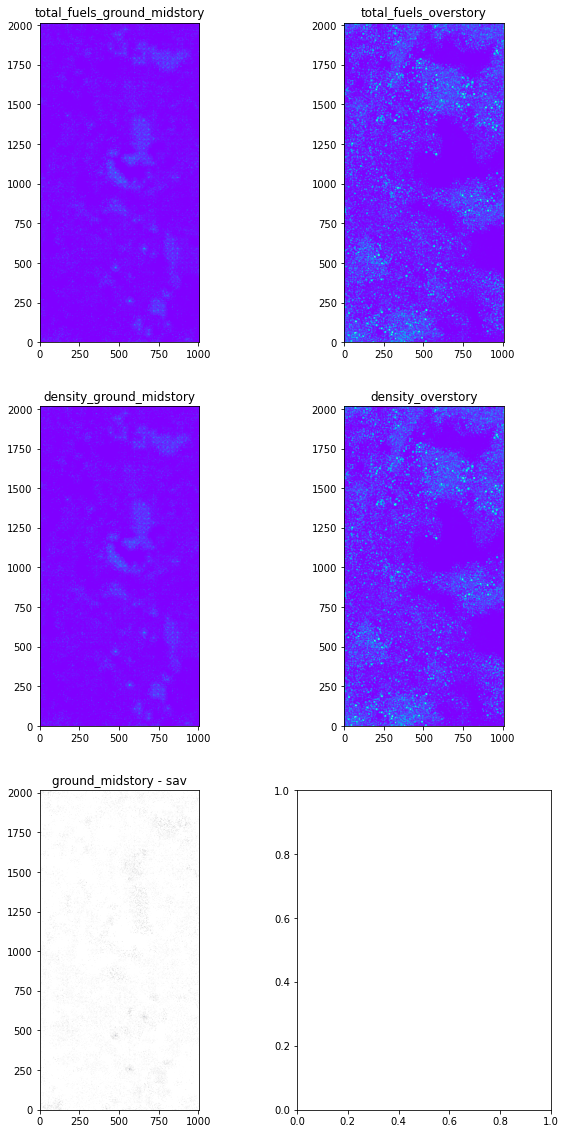

In [70]:
fig, ax = plt.subplots(3,2,figsize=(10,20))

ax[0,0].imshow(total_fuels_ground_midstory, cmap='rainbow', origin="lower")
ax[0,0].set_title('total_fuels_ground_midstory')

ax[0,1].imshow(total_fuels_overstory, cmap='rainbow', origin="lower")
ax[0,1].set_title('total_fuels_overstory')


ax[1,0].imshow(density_ground_midstory, cmap='rainbow', origin="lower")
ax[1,0].set_title('density_ground_midstory')

ax[1,1].imshow(density_overstory, cmap='rainbow', origin="lower")
ax[1,1].set_title('density_overstory')


ax[2,0].imshow(ground_midstory, cmap='rainbow', origin="lower")
ax[2,0].set_title('ground_midstory - sav')

#ax[2,1].imshow(overstory, cmap='rainbow', origin="lower")

### visualize 3-d overstory surface-area-to-volume (sav)

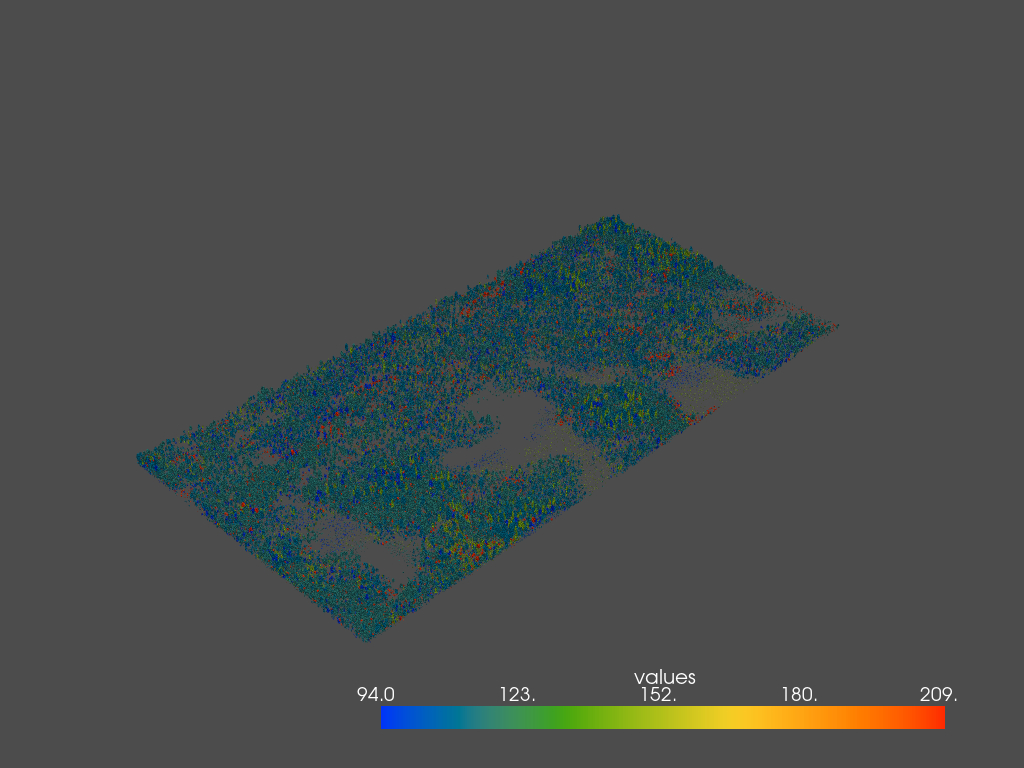

[(3523.7367250135417, 3018.7367250135417, 2543.2367250135417),
 (1008.5, 503.5, 28.0),
 (0.0, 0.0, 1.0)]

In [68]:
plotter = pv.Plotter(title='FastFuels')

# move zeros to -1 for thresholding
overstory[overstory == 0] = -1

# convert the 3D array to a Pyvista UniformGrid
grid = pv.UniformGrid()
grid.dimensions = np.array(overstory.shape) + 1
grid.spacing = [1,1,1]
grid.cell_arrays['values'] = overstory.flatten(order='F')
grid = grid.threshold(0)

# add the array to the plotter instance
plotter.add_mesh(grid, cmap='rainbow')
      

plotter.show()

### kmeans clustering

In [71]:
#reshape to 2d for kmeans
ground_midstory_reshape = ground_midstory.reshape(( -1 , 4 ))
overstory_reshape = overstory.reshape(( -1 , 124 ))

In [72]:
ground_midstory.shape

(2017, 1007, 4)

In [73]:
#reshape to 2d for kmeans
ground_midstory_reshape = ground_midstory.reshape(( -1 , 4 ))
overstory_reshape = overstory.reshape(( -1 , 124 ))

In [74]:
ground_midstory_reshape.shape

(2031119, 4)

### determine number of clusters

Text(0, 0.5, 'Within Cluster Sum of Squares (WCSS)')

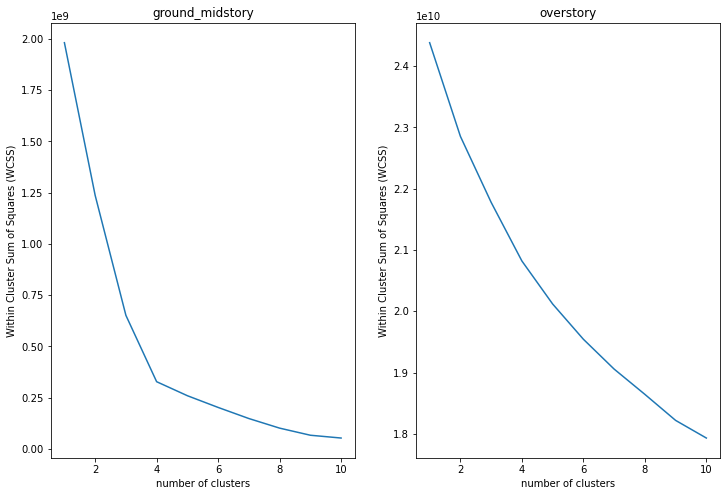

In [75]:
# Using the elbow method to find the optimal number of clusters
#  Find "crook of elbow" looking at Within-Cluster-Sum-of-Squares (WCSS) metric

wcss_ground_midstory = []
wcss_overstory = []


for i in range(1,11):
    kmeans_ground_midstory_reshape = KMeans(n_clusters = i)
    kmeans_ground_midstory_reshape.fit(ground_midstory_reshape)
    wcss_ground_midstory.append(kmeans_ground_midstory_reshape.inertia_)
    
    
    kmeans_overstory_reshape = KMeans(n_clusters = i)
    kmeans_overstory_reshape.fit(overstory_reshape)
    wcss_overstory.append(kmeans_overstory_reshape.inertia_)
    
    
fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].plot(range(1,11), wcss_ground_midstory, label="ground_midstory")
ax[1].plot(range(1,11), wcss_overstory, label="overstory")

#fig.suptitle("elbow method for determining number of clusters - comparing ground/midstory and overstory for density", fontsize=14);
ax[0].set_title('ground_midstory')
ax[1].set_title('overstory')

ax[0].set_xlabel('number of clusters')
ax[1].set_xlabel('number of clusters')
ax[0].set_ylabel('Within Cluster Sum of Squares (WCSS)')
ax[1].set_ylabel('Within Cluster Sum of Squares (WCSS)')
#ax[0].legend()

### numberof clusters, n = 4 based on crook for ground/midstory.  harder to tell for overstory.

### moving forward with kmeans clustering with n=4

In [79]:
# comparing ground/midstory and overstory (n_clusters=4) total fuels

# classify total fuels into different number of clusters

kmeans_ground_midstory_tf = KMeans(n_clusters = 4)
kmeans_ground_midstory_tf.fit(total_fuels_ground_midstory)
cluster_centers_ground_midstory_tf = kmeans_ground_midstory_tf.cluster_centers_
cluster_labels_ground_midstory_tf = kmeans_ground_midstory_tf.labels_
    
kmeans_overstory_tf = KMeans(n_clusters = 4)
kmeans_overstory_tf.fit(total_fuels_overstory)
cluster_centers_overstory_tf = kmeans_overstory_tf.cluster_centers_
cluster_labels_overstory_tf = kmeans_overstory_tf.labels_
    

# comparing ground/midstory and overstory (n_clusters=4) density

# classify density into different number of clusters

kmeans_ground_midstory_density = KMeans(n_clusters = 7)
kmeans_ground_midstory_density.fit(density_ground_midstory)
cluster_centers_ground_midstory_density = kmeans_ground_midstory_density.cluster_centers_
cluster_labels_ground_midstory_density = kmeans_ground_midstory_density.labels_
    
kmeans_overstory_density = KMeans(n_clusters = 5)
kmeans_overstory_density.fit(density_overstory)
cluster_centers_overstory_density = kmeans_overstory_density.cluster_centers_
cluster_labels_overstory_density = kmeans_overstory_density.labels_
    


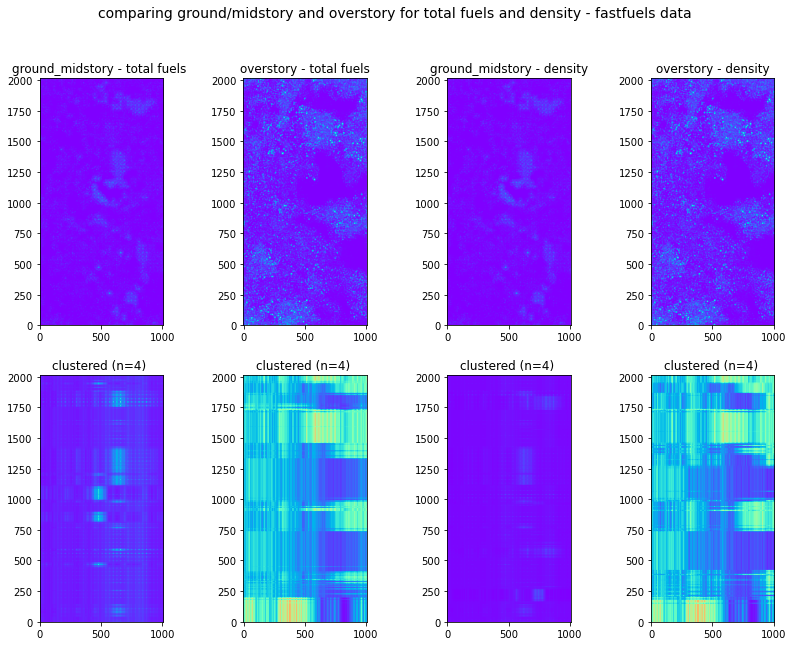

In [81]:
fig, ax = plt.subplots(2,4,figsize=(14,10))

ax[0,0].imshow(total_fuels_ground_midstory, cmap='rainbow', origin="lower")
ax[1,0].imshow(cluster_centers_ground_midstory_tf[cluster_labels_ground_midstory_tf], cmap='rainbow', origin="lower")
ax[0,0].set_title('ground_midstory - total fuels ')
ax[1,0].set_title('clustered (n=4) ')

ax[0,1].imshow(total_fuels_overstory, cmap='rainbow', origin="lower")
ax[1,1].imshow(cluster_centers_overstory_tf[cluster_labels_overstory_tf], cmap='rainbow', origin="lower")
ax[0,1].set_title('overstory - total fuels')
ax[1,1].set_title('clustered (n=4) ')




ax[0,2].imshow(density_ground_midstory, cmap='rainbow', origin="lower")
ax[1,2].imshow(cluster_centers_ground_midstory_density[cluster_labels_ground_midstory_density], cmap='rainbow', origin="lower")
ax[0,2].set_title('ground_midstory - density')
ax[1,2].set_title('clustered (n=4) ')

ax[0,3].imshow(density_overstory, cmap='rainbow', origin="lower")
ax[1,3].imshow(cluster_centers_overstory_density[cluster_labels_overstory_density], cmap='rainbow', origin="lower")
ax[0,3].set_title('overstory - density')
ax[1,3].set_title('clustered (n=4) ')


fig.suptitle("comparing ground/midstory and overstory for total fuels and density - fastfuels data", fontsize=14);




#fig.suptitle("comparing ground/midstory and overstory (n_clusters) total fuels fastfuels data", fontsize=14);

### save models to pickle files for future inference

In [84]:
pickle.dump(kmeans_ground_midstory_tf, open("kmeans_model_total_fuels_ground_midstory.pkl", "wb"))
pickle.dump(kmeans_overstory_tf, open("kmeans_model_total_fuels_overstory.pkl", "wb"))
pickle.dump(kmeans_ground_midstory_density, open("kmeans_model_density_ground_midstory.pkl", "wb"))
pickle.dump(kmeans_overstory_density, open("kmeans_model_density_overstory.pkl", "wb"))